In [1]:
## if not install using pip
## assume source code irasa is in folder code, if so then add relative path for code to python path as below
import sys
sys.path.insert(0,'../code')

In [2]:
from irasa import *

## helper function in module plotting, sets matplotlib plotting parameters
plot_style(fs=14)


## Synthetic data example

This is generates a fake spectrum by adding a Gaussian peak to a colored spectrum. Then takes the inverse FFT to generate a signal. 

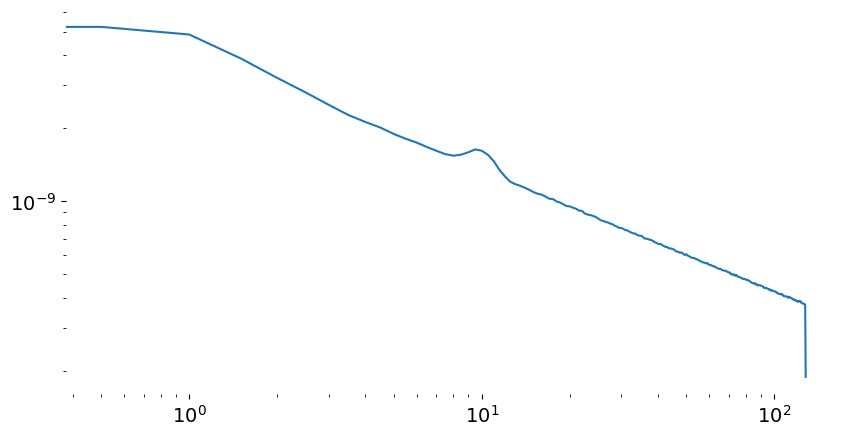

In [23]:
# Oscillatory parameters
peak_center_freq = 10  # Hz
peak_amplitude = 1.5e-1
peak_width = 1 # standard deviation in Hz

periodic_params = [(0.75, peak_amplitude, peak_width),(peak_center_freq, peak_amplitude, peak_width)]

a = syn_1f_signal(exponent=0.5,periodic_params = periodic_params, duration = 120*60)
a.gensignal()

f,p = welch(a.full_signal,fs = a.sample_rate,nperseg=int(2*a.sample_rate))

plt.plot(f,p)
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')

Now process through IRASA to recover the oscillatory and aperiodic components. 

>Note:
>1.  Artifact near the edges of the spectra. This is due to shifting the frequencies where there is no power in the original series. This is important to note in cases where bandpass filtering is used prior to applying IRASA. Bandpass filtering may produce artifacts in bands of interest. 
>2. Negative power near osc peak. This is a limitation of IRASA. It produces artifactual peaks that are added to the aperiodic spectrum. 

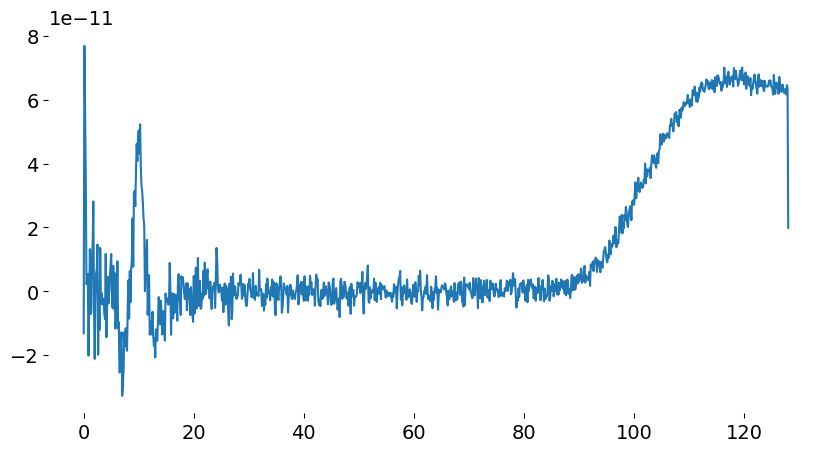

In [24]:
win_sec = 8

freqs, psd_raw,psd_ap, psd_osc = irasa(a.full_signal,sf=a.sample_rate,win_sec=win_sec)

## plot osc component
# px.line(x=freqs,y=psd_osc)

plt.plot(freqs,psd_osc)



Plot resampled spectra, and resultant aperiodic and osc components.

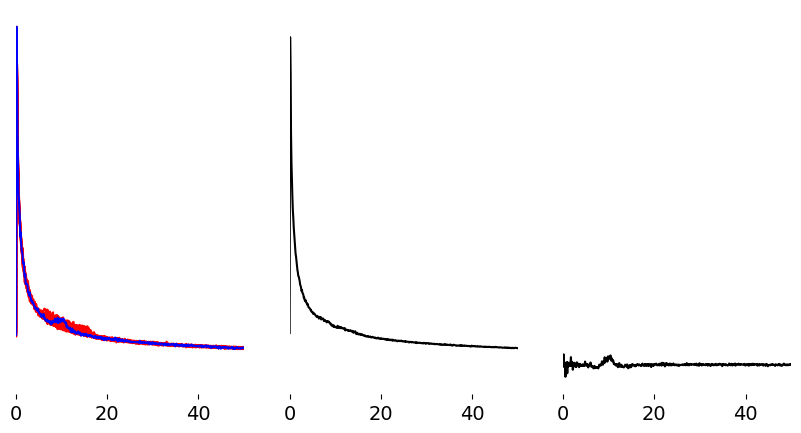

In [25]:
x = a.full_signal
sf = a.sample_rate
win_sec = 10

fig,ax = plt.subplots(1,3,figsize=(10,5),sharey=True)
ax = ax.reshape(-1)

h_ = np.linspace(1.01,1.5,5)
kwargs_welch = dict(average='median', window='hamming',scaling='spectrum')
freqs, psd_raw = welch(x, sf, nperseg=int(sf*win_sec), **kwargs_welch)#,nfft=int(sf*win_sec))
cross_spect = np.zeros((len(h_),len(psd_raw)))
for i,h in enumerate(h_):
    # print(h)
    h = np.round(h,4)
    # Get the upsampling/downsampling (h, 1/h) factors as integer
    rat = fractions.Fraction(str(h))
    up, down = rat.numerator, rat.denominator
    data_up = resample_poly(x, up, down, axis=-1)
    data_down = resample_poly(x, down, up, axis=-1)
    
    # Calculate the PSD using same params as original
    freqs_up, psd_up = welch(data_up, h * sf, nperseg=int(sf*win_sec), **kwargs_welch)#,nfft=int(sf*win_sec))
    freqs_dw, psd_dw = welch(data_down, sf / h, nperseg=int(sf*win_sec), **kwargs_welch)#,nfft=int(sf*win_sec))
    # print((len(data_up),len(data_down)))
    # Geometric mean of h and 1/h
    cross_spect[i, :] = np.sqrt(psd_up * psd_dw)
    ax[0].plot(freqs,1/h**0.5*psd_up,'r')
    ax[0].plot(freqs,h**0.5*psd_dw,'r')

psd_aperiodic = np.median(cross_spect,0)
psd_osc = psd_raw - psd_aperiodic

ax[0].plot(freqs,psd_raw,'b')

ax[1].plot(freqs,psd_aperiodic,'k')

ax[2].plot(freqs,psd_osc,'k')

for i in range(3):
    ax[i].set_xlim(0,50)
    ax[i].set_yticks([])


## Physionet example

In [26]:
data = fetch_data(subjects=[3], recording=[1])[0]

raw = mne.io.read_raw_edf(data[0], stim_channel='Event marker',
                                misc=['Temp rectal'])
annot = mne.read_annotations(data[1])

dfstg = mneannot_2_dfstg(annot,raw,dic_stg2num)

dfstg

Using default location ~/mne_data for PHYSIONET_SLEEP...
Extracting EDF parameters from /Users/sv54/mne_data/physionet-sleep-data/SC4031E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


,epoch,seconds,stage
datetime,,,
1989-04-10 16:50:00+00:00,0,0,0
1989-04-10 16:50:30+00:00,1,30,0
1989-04-10 16:51:00+00:00,2,60,0
1989-04-10 16:51:30+00:00,3,90,0
1989-04-10 16:52:00+00:00,4,120,0
...,...,...,...
1989-04-11 16:17:30+00:00,2815,84450,0
1989-04-11 16:18:00+00:00,2816,84480,0
1989-04-11 16:18:30+00:00,2817,84510,0


#### Generate IRASA spectrogram





In [27]:
win_sec = 10

a = irasa_spectrogram(raw_mne=raw,ch='EEG Fpz-Cz',dfstg=dfstg,win_sec=win_sec)

a.spectrogram()

## runs irasa over the entire series, not in epochs
# a.irasa_alltime()

  0%|          | 0/2820 [00:00<?, ?it/s]

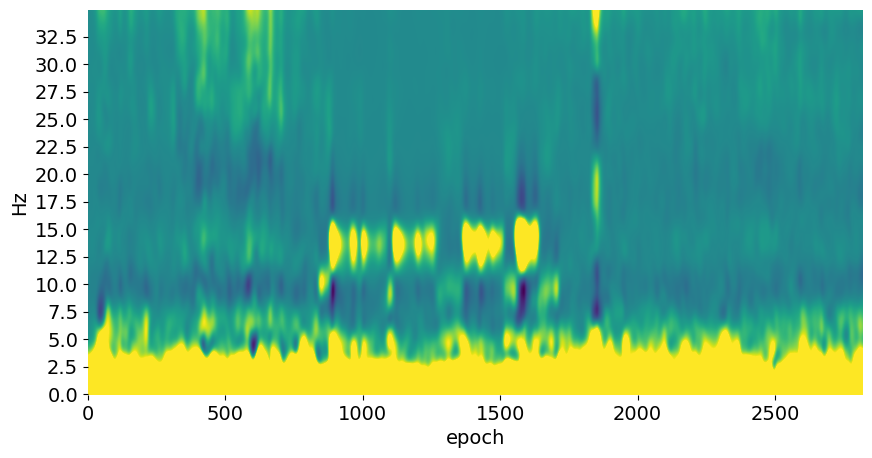

In [29]:
X = a.Xosc

# normbd = (int(0.5*win_sec),int(15*win_sec)+1)
# bdnorm = np.tile(np.sum(X[normbd[0]:normbd[1],:],0),[np.shape(X)[0],1])
# Xn = X/bdnorm

# Xns = smoothX_2D(Xn)

Xs = smoothX_2D(X)

normbd = (int(0.5*win_sec),int(35*win_sec)+1)
bdnorm = np.tile(np.max(Xs[normbd[0]:normbd[1],:],0),[np.shape(Xs)[0],1])

Xns = Xs/bdnorm

Xns = Xns[:int(35*win_sec),:]

freqs = a.irasa_freqs[:int(35*win_sec)]

plt.imshow(Xns,origin='lower',vmax=1e-1,aspect='auto')
ind_ = np.arange(0,len(freqs),25)
plt.gca().set_yticks(ind_);
plt.gca().set_yticklabels(freqs[ind_]);
plt.gca().set_xlabel('epoch');
plt.gca().set_ylabel('Hz');

plt.savefig('../figures/norm_irasa_spec.png',format='png',dpi=200)

In [30]:

bands = {}
bands['swa'] = (0.5,4)
bands['theta'] = (4,8)
bands['htheta'] = (8,11)
bands['beta'] = (20,30)


indf = int(win_sec)

df = pd.DataFrame(columns= list(bands.keys()))

for bd in bands.keys():
    f0 = bands[bd][0]
    f1 = bands[bd][1]
    x = np.mean(Xns[int(indf*f0):int(indf*f1),:],axis=0)
    df[bd] = x


df['stage'] = a.stage

df

,swa,theta,htheta,beta,stage
0,0.397162,0.011416,-0.004208,0.005838,0.0
1,0.397258,0.011488,-0.004220,0.005849,0.0
2,0.397441,0.011630,-0.004245,0.005872,0.0
3,0.397692,0.011842,-0.004279,0.005906,0.0
4,0.397988,0.012122,-0.004320,0.005952,0.0
...,...,...,...,...,...
2815,0.649556,0.058501,-0.006896,-0.010406,0.0
2816,0.653518,0.057071,-0.006929,-0.011629,0.0
2817,0.656460,0.055840,-0.006953,-0.012587,0.0
2818,0.657892,0.054893,-0.006965,-0.013236,0.0


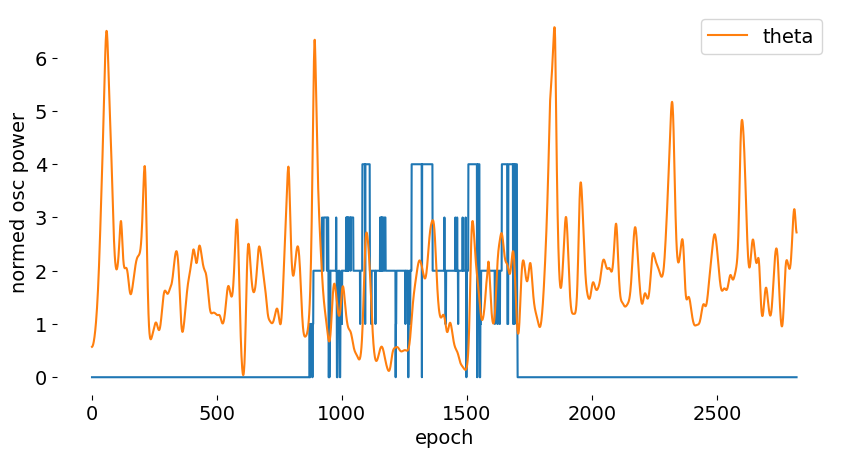

In [36]:
plt.plot(df.stage)
plt.plot(5e1*df.theta,label='theta')
plt.legend()
plt.ylabel('normed osc power');
plt.xlabel('epoch');



